# Anomaly detection from raw images (all objects) - training

**Motivation**:

In this Notebook I will investigate if we can identify anomalies based on the patterns encoded in the raw images.

There could be a process running in real time, which would tell the difference between the normal and unusual images, and based on that, it could send notifications to the users about suspicious activities.

On average, object detection process identifies $2000$ images each day. It is very tedious to scan through all of them every day, so if we could find a metric for anomalousness, we could sort the images by the "most different ones", and send a daily email to the users with the key events.

In the *Deep Learning for Anomaly Detection: A Survey* paper (Chalapathy 2019), author mentions that even though the field of anomaly detection has been well explored by scientists, and Deep Learning is highly popular across researchers, these two areas are not linked enough and there are a lot of opportunities to explore.

Finding anomalies based on the camera frames can be framed as an unsupervised Machine Learning problem, where we train a model to learn classifying anomalies from the raw image content.

We are using an unsupervised learning, as there are over $600,000$ images collected in the process, without any labels and anomaly versus not-anomaly classes will be highly imbalanced (with potentially less than $1\%$ of anomalous images).

The idea, which will be explored in this Notebook, is to build a Deep Learning model, which learns from the training data to reconstruct the most common images (not-anomalous). Then, when it comes aross an anomaly, it will reconstruct it with a high error. When this error is higher than some threshold, we classify observation as anomalous.

These type of models are called the *Auto Encoders*. They have some other use cases as well, like data compression or noise removal, but I will utilise a Convolution-based auto encoder to detect anomalies from the image dataset with detected objects.

What is different in comparison to the previous method (Anomalies estimated from event counts), is that auto encoders will use the data for all object classes.

**Training strategy:**
- load raw images from the disk
- preprocess images
- reshape/normalize data
- split dataset into train and test sets
- define autoencoder architecture
- train autoencoder and analyse training results
- use test set and see which results produced the highest error
- find an error threshold based on the percentage of images we want to classify as anomalous (for example 0.7%)

In [4]:
# import ConfigImports Notebook to import and configure libs
%run ../Config/ConfigImports.ipynb

### Load dataset and clean it up

First, lets load a dataframe with all image dates and filenames from a previously stored parquet file.

Then lets remove the outage dates.

In [5]:
df = pd.read_parquet('../Datasets/AllObjectDetections_2019-09-09_2020-03-02.parquet.gzip')
df = df.drop(labels=['index'], axis=1)
df.head(2)

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min
0,72846,car,0.523175,298,7,426,71,2019-09-09,07.02.40,07.02.40.270_34c99836_car-car-car.jpg,1,270,2019-09-09 07:02:40.270,Monday,False,9,7,2
1,72847,person,0.759682,489,31,518,106,2019-09-09,12.02.42,12.02.42.921_ea6c9143_person-bicycle.jpg,2,921,2019-09-09 12:02:42.921,Monday,False,9,12,2


In [6]:
idx = df['date'].isin(CONFIG['DOWNTIME_DATES'])
df = df.loc[~idx]
df.shape

(643471, 18)

### Computer Vision

Raw images themselves can be very useful for many purposes (like forensic investigations, automated alerts, or simply historical value), but they need some form of pre-processing before they can be used for Machine Learning.

Computer Vision is a vast area of Artificial Intelligence, which provides plethora of guidelines and solutions for image processing and image content analysis.

First, we need a quick way of displaying images in the Notebook. This is handled by the `imshow` function below, which is flexible enough to handle 3 types of inputs to display an image:
- image file path
- image as numpy array
- grayscale and color images

Next, I have defined the `process_frame` function, which allows to perform morphological operations on images using flags as function arguments. It was partially inspired by a post on PyImageSearch (PyImageSearch 2017): 
- convert to gray scale 
- apply Median blur
- apply Thresholding
- crop ROI using polyfill

In [7]:
def imshow(img, width=12, height=6):
    """
    Show image using matplotlib. Function takes a path or a 
    numpy image and renders it in RBG color-space
    """
    if isinstance(img, str):
        img = cv2.imread(img)
    rcParams['figure.figsize'] = width, height
    plt.axis('off')
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
    plt.show()

def process_frame(frame, dims, is_gray=True, is_blur=False, is_thresh=False, is_polyfill=False,
                  poly_values=None, debug_poly=False):
    """
    Preprocess frame for Machine Learning:    
    - resize to desired size to improve performance and reduce noise
    - change to gray scale to improve performance and remove color variances
    - apply Gaussian blur to remove noise
    - threshold to partition an image into foreground and background
    - mask out an area of an image bases on a poly shape
    """
    if frame is None or frame.shape[0] == 0:
        raise ValueError('Error: issue with frame!')
    frame = cv2.resize(frame, dims)
    if is_gray:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    if is_blur:
        frame = cv2.medianBlur(frame, 3)
        # frame = cv2.GaussianBlur(frame, (11, 11), 0)
        #frame = cv2.erode(frame, None, iterations=1)
        #frame = cv2.dilate(frame, None, iterations=2)
    if is_thresh:
        frame = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    if is_polyfill:
        wh  = np.array([frame.shape[0], frame.shape[1]])
        poly_shape = np.array([poly_values * wh]).astype(np.int32)
        cv2.fillConvexPoly(frame, poly_shape, (0, 0, 0))
        if debug_poly:
            for points in poly_shape:
                for i, p in enumerate(points):
                    text_points = (p[0] + 2 if p[0] < wh[0] else p[0] - 18, p[1] + 24)
                    frame = cv2.circle(frame, tuple(p), 3, (0,255,0), 3)
                    cv2.putText(frame, str(i), text_points, cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, (0,0,255), 2)
    return frame

### Image processing examples

Below are a few examples of how an image will look  when various image processing techniques are applied. Let's take a look at the original image we will be testing first:

(720, 1280, 3)


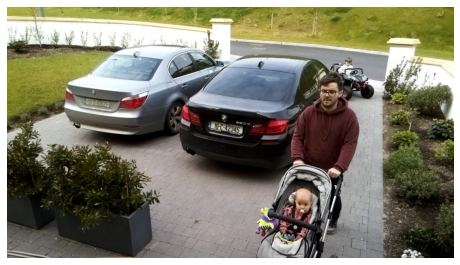

In [8]:
im_path = '../Datasets/anomalies_labelled/1/09.10.53.914_847073c1_person-person-motorbike.jpg'
# im_path = '/data/security_cam_detections_v2/Front-Parking/2019-12-16/08.39.24.685_1a00446f_car.jpg'
im_raw = cv2.imread(im_path)
imshow(im_raw, 8)

And now we can see the same image processed in 3 different ways:
- blurred
- thresholded
- polyfilled

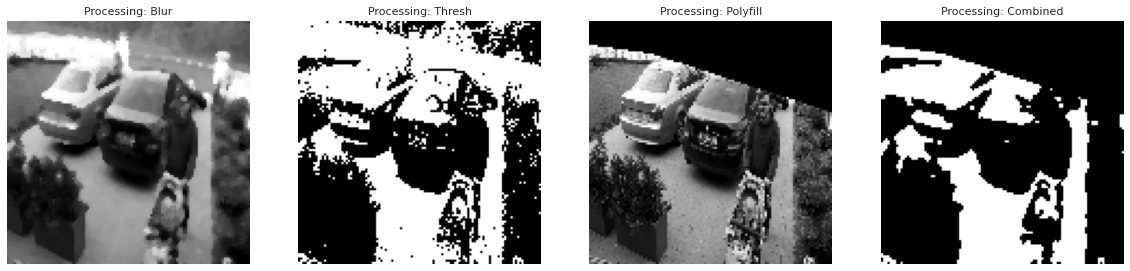

In [11]:
WIDTH, HEIGHT = 112, 112
POLY_VALUES = np.array([[0, 0], [1, 0], [1, 0.37], [0.5, 0.21], [0.25, 0.13], [0, 0.09]])  # poly-shape to mask
params = (
    ('Blur', True, False, False),
    ('Thresh', False, True, False),
    ('Polyfill', False, False, True),
    ('Combined', True, True, True)
)
fig = plt.figure(figsize=(20,10)) # specifying the overall grid size

for i, p in enumerate(params):
    plt.subplot(1, 4, i+1)    # the number of images in the grid is 1*4
    img = process_frame(im_raw.copy(), (WIDTH, HEIGHT), is_gray=True, is_blur=p[1],
                        is_thresh=p[2], is_polyfill=p[3], poly_values=POLY_VALUES)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Processing: {p[0]}', fontdict={'fontsize': 11})
    plt.axis('off')
plt.show()

### Unsupervised Learning with Auto Encoders / Data Preparation

As the dataframe at the start only contains a list of all images stored on the disk, we need to extract the raw data from the images.

The procedure of extracting the raw image content consists of the following steps:
- pre-allocate memory in 2 numpy arrays: one for the image data and one for corresponding filenames
- take a sample of images from the dataframe
- iterate through the sampled dataframe and for each record:
    - open an image from the disk
    - process image using `process_frame` function by using provided pre-processing parameters
        - here we also need to handle the case when image is not readable (missing or corrupted)
    - append image data (as numpy array) and corresponding filename to the numpy arrays

#### Image size - extra caution!

We need to be extra careful about the resolution of the images. The higher resolution we will use, the more detail will be available to the Deep Learning model, but it comes at a cost.

Single gray-scale $28x28$ pixel image will generate a record with $784$ features and an image with the size $112x112$ will result in $12,544$ features respectively.

Since the original images' shape is $720x1280x3$, if we wanted to use the original images it would result in $2,764,800$ features only for a single image!

Based on my experiments increasing size to more than $608x608$ tends to cause issues with the GPU memory and it actually degrades the performance of the model, as it learns too much noise (like leaves, shadows, objects moved by wind etc.)

Another issue with the high image quality is the speed of image pre-processing and model training, and it is a difference between 2 minutes and 35 minutes on a single model training.

For all the above reasons I will only consider image sizes 28x28 and 56x56 in the rest of this Notebook.

Now we can define a function called `process_img_batch`, which will prepare images for the training step.

In [12]:
def process_img_batch(samples, im_width, im_height, is_blur, is_thresh, is_poly, poly_values=None):
    """
    Pre-process multiple images in the sample and return images
    and corresponding filenames as a tuple.
    If an image does not exist on the disk or if it can not be opened,
    a previous image will be appended to the results.
    Parameters
    ----------
    samples : pd.DataFrame
        DataFrame containing date and filename features
    im_width : int
        Width of image to resize to
    im_height : int
        Height of image to resize to
    is_blur : bool
        Should image be blured
    is_thresh : bool
        Should image be thresholded
    is_poly : bool
        Should image be masked
    poly_values : np.array
        Polygon (convex) shape to mask in the image
    Returns
    -------
    tuple
       List of images in numpy arrays and list of
       corresponding filenames -> (np.array, np.array)
    """
    
    # pre-allocate memory for the image data
    im_data = np.zeros((samples.shape[0], im_width, im_height), dtype='uint8')
    im_filepaths = []

    # iterate through images and store in previously defined numpy array
    im_processed_prev = None
    im_path_prev = None
    for i, (im_date, im_filename) in tqdm(enumerate(samples[['date', 'filename']].to_numpy())):
        im_path = f'{CONFIG["IMG_BASE_DIR"]}/{im_date}/{im_filename}'
        im_raw = cv2.imread(im_path)
        try:
            im_processed = process_frame(im_raw, (im_width, im_height), is_gray=True, is_blur=is_blur,
                                         is_thresh=is_thresh, is_polyfill=is_poly, poly_values=poly_values)
        except Exception as e:
            # if exception occurs when reading image, use previous image again
            print('Exception, will use previous image instead.', str(e), im_path)
            im_data[i] = im_processed_prev
            im_filepaths.append(im_path_prev)
            continue
        im_processed_prev = im_processed.copy()
        im_path_prev = im_path
        im_data[i] = im_processed
        im_filepaths.append(im_path)
    im_filepaths = np.array(im_filepaths)
    
    return im_data, im_filepaths

To keep track of how different models and proprocessing steps perform, I have created a `scores.csv` file. The below code snippet will initialize a `SCORE_HISTORY` DataFrame with all the scores.

In [13]:
# initialize score history, so we can keep track of
# the models and their performance, if already exists, read
# from file, otherwise create a new dataframe for it
try:
    SCORE_HISTORY = pd.read_csv('../Datasets/model_scores/scores.csv')
except FileNotFoundError as e:
    SCORE_HISTORY = pd.DataFrame(columns=['model_name', 'acc', 'prec', 'rec', 'f1'])

Now we can prepare a sample dataset by sampling a $10,000$ records from the dataframe `df` with the image filenames.

In the preprocessing step I am passing the `POLY_VALUES` numpy array to mask the region, which we don't want the model to observe for changes (for example if we are not interested in anomalies on the street or footpath).

During my experiments I found that $28x28$ or $56x56$ resolutions are sufficient to achieve good results, and they are faster to execute than larger image dimensions and require less compute power. For the rest of the experiment, I will be using $10K$ images with $56x56$ resolution.

In [93]:
%%time
# sample records from the dataframe
NUM_ROWS = 10000
samples = df.sample(NUM_ROWS, random_state=CONFIG['RANDOM_STATE'])  # provide random_state for reproducibility

# set image properties and model name
WIDTH, HEIGHT = 56, 56
model_name = f'nsamples{NUM_ROWS}_res{WIDTH}_blurTrue_threshTrue_polyTrue'

# pre-process images into a numpy array and save datasets on disk for future reference
im_data, im_filepaths = process_img_batch(samples, WIDTH, HEIGHT, True, True, True, POLY_VALUES)

# overwrite model name if required
# model_name = f'nsamples{NUM_ROWS}_res{WIDTH}_blurTrue_threshTrue_polyTrue_RELU_NO_LR_DECAY'

Exception, will use previous image instead. Error: issue with frame! /data/security_cam_detections_v2/Front-Parking/2020-02-08/23.33.40.184_2c97eae7_person.jpg

CPU times: user 1min 38s, sys: 832 ms, total: 1min 39s
Wall time: 1min 40s


How long does it take to preprocess the images?

I turned out that the computer vision operations are very fast, and the main factor infuencing the speed is just the number of images to process.

In my experiments (on Intel i5 with NVME M2 Solid State Drive), I have collected the following statistics for the 28x28 images with all computer vision operations enabled:

| Sample Size | Time To Process |
| ----------- | --------------- |
| 1,000       | 10.1 s          |
| 10,000      | 1min 40s        |
| 25,000      | 4min 20s        |
| 50,000      | 8min 35s        |

It is always worth looking into the RAM consumption. In case of $10K$ records, it's around 35MB, and with larger data samples of greater resolutions, this can easily go to a few GB.

Next, we need to add additional dimension to the dataset, as Neural Network will expect the shape of (height, width and depth). The depth is in case if we wanted to use the color images.

Now we can normalize the data on a 0-1 scale. Since image data is a `uint8` type, it can take values only between 0 and 255, so dividing all values by 255.0 is the standard normalisation step for image data. We just need to remember that normalized data becomes a `float32` type:

$$normalize(X)=X/255.0$$

And the last step here is to split the dataset into train and test splits. Unfortunately due to slow training times it is not adviced to run cross validation splits for Deep Neural Networks. I am choosing a 0.8 / 0.2 split with a `random_state` parameter set to a constant value for reproducibility reasons.

In [94]:
print(f'Training Data sample shape: {im_data.shape}')
print(f'Size in RAM: {round((im_data.size * im_data.itemsize) / 1024 / 1024, 2)} MB')
print(f"{round(NUM_ROWS / df.shape[0], 3) * 100}% of overall dataset ({NUM_ROWS} out of {df.shape[0]} data points)")

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
im_data = np.squeeze(im_data)
im_data = np.expand_dims(im_data, axis=-1)
im_data = im_data.astype("float32") / 255.0
print(f'Data reshaped shape: {im_data.shape}')

# construct the training and testing split,
# use random_state for reproducability, remove it
# in prodocuction
X_train, X_test, y_train, y_test = train_test_split(im_data, im_filepaths,test_size=0.2,
                                                    random_state=CONFIG['RANDOM_STATE'])
print(f'Train shape: {X_train.shape}, test shape: {X_test.shape}')

Training Data sample shape: (10000, 56, 56)
Size in RAM: 29.91 MB
1.6% of overall dataset (10000 out of 643471 data points)
Data reshaped shape: (10000, 56, 56, 1)
Train shape: (8000, 56, 56, 1), test shape: (2000, 56, 56, 1)


### Unsupervised Learning with Auto Encoders / Training

Now we can move to the training process.

Below is a Convolutional auto encoder Neural Network architecture inspired by a blog entry on PyImageSearch (PyImageSearch 2020):

$$
autoEncoder=decoder(encoder(X))
$$

- Encoder:
    - Input: X_train
    - Convolutional layer: $32$ and $64$ filters, each followed by Leaky ReLU and Batch Normalization:
        - changing the size of filters or adding/removing filters have decreased the performance
        - the difference between ReLU and Leaky ReLU activations is very small, but Leaky ReLU seems to be a little more robust. I have concluded that letting some weights to be slightly negative makes a difference
    - Output: Latent (bottleneck) layer with $16$ nodes by default. Experiments with different sizes ($8$ and $32$) did not make any improvements, where $8$ nodes has decreased the performance by around $10\%$
- Decoder:
    - Input: Latent layer
    - Convolutional transpose layer: $32$ and $64$ filters, each followed by Leaky ReLU and Batch Normalization
    - Single CNN layer: this layer is used to recover the original depth
    - Activation: Sigmoid is used to make sure output values match the input range (between $0$ and $1$)
- Optimizer: Adam with learning rate $\alpha$ and decay $decay=\alpha \div nEpochs$
    - Switching optimizers to Stochastic Gradient Descent or RMS-Prop did not improve the model's performance
- Loss: mean squared error is used as a simple and well understood error function, which will be used below to identify anomalies

I am leaving out the theory behind the Neural Network layers, as it is constantly repeated across papers and does not make this section any useful. Hopefully the intuition, which is provided above, is more valuable.

After many experiments with different model parameters, I have concluded that the architecture defined below is quite optimal in its original shape.

In [95]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, ReLU
from tensorflow.keras.layers import Activation, Flatten, Dense, Reshape, Input
from tensorflow.keras import backend as K, Model
from tensorflow.keras.optimizers import Adam

def build_ae(im_width, im_height, depth=1, latent_dim=16, cnn_filters=(32, 64), lr=1e-3, epochs=50):
    """
    Build an auto-encoder NN architecture using Keras functional
    API and return a tuple of: auto-encoder, encoder and decoder
    Parameters
    ----------
    im_width : int
        Width of image to resize to
    im_height : int
        Height of image to resize to
    depth : int
        Number of channels in the images
    latent_dim : int
        Number of neurons in the latent (compressed) layer
    cnn_filters : tuple
        Tuple of integers with number of filters to use in Convolutional layers
    lr : float
        Learning rate for the optimizer
    epochs:
        Epochs will be used to calculate the learning rate decay (lr / epochs)
    Returns
    -------
    tuple
       Tuple of Keras models (auto-encoder, encoder and decoder)
    """
    
    # define model params
    input_shape = (im_height, im_width, depth)
    chan_dim = -1

    # define the input to the encoder
    inputs = Input(shape=input_shape)
    x = inputs
    # loop over the number of filters
    for f in cnn_filters:
        # apply a CONV => RELU => BN operation
        x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chan_dim)(x)
    # flatten the network and then construct our latent vector
    volume_size = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, name="latent")(x)
    # build the encoder model
    encoder = Model(inputs, latent, name="encoder")

    # start building the decoder model which will accept the
    # output of the encoder as its inputs
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(np.prod(volume_size[1:]))(latent_inputs)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
    # loop over our number of filters again, but this time in
    # reverse order
    for f in cnn_filters[::-1]:
        # apply a CONV_TRANSPOSE => RELU => BN operation
        x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chan_dim)(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)
    # build the decoder model
    decoder = Model(latent_inputs, outputs, name="decoder")

    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    # set up an optimised with learning rate decay
    opt = Adam(lr=lr, decay=lr / epochs)
    
    # compile model with mean squared error loss function
    autoencoder.compile(loss="mse", optimizer=opt)
    
    # return all 3 models
    return autoencoder, encoder, decoder

Now we are ready to build the auto-encoder model. We can call the Keras `model.summary` method, which displays a number of trainable parameters.

Given the CNN-based architecture above and 56x56 image size, the model has almost 500K parameters. This number goes up to 1.7M if we choose 112x112 images.

In [110]:
# build coanvolutional auto-encoder, override default epoch size,
# this will be used to set the optimizer's learning rate decay
EPOCHS = 15
ae, enc, dec = build_ae(WIDTH, HEIGHT, epochs=EPOCHS, latent_dim=16)
ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 56, 56, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                219920    
_________________________________________________________________
decoder (Model)              (None, 56, 56, 1)         269313    
Total params: 489,233
Trainable params: 488,849
Non-trainable params: 384
_________________________________________________________________


In [111]:
# use this to train a new model
BS = 32
H = ae.fit(X_train, X_train, validation_data=(X_test, X_test),
           epochs=EPOCHS, batch_size=BS, verbose=1)  # verbose to 1 to display training output

Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 3s 325us/sample - loss: 0.0472 - val_loss: 0.1790
Epoch 2/15
8000/8000 [==============================] - 2s 268us/sample - loss: 0.0255 - val_loss: 0.0386
Epoch 3/15
8000/8000 [==============================] - 2s 249us/sample - loss: 0.0222 - val_loss: 0.0216
Epoch 4/15
8000/8000 [==============================] - 2s 256us/sample - loss: 0.0200 - val_loss: 0.0204
Epoch 5/15
8000/8000 [==============================] - 2s 259us/sample - loss: 0.0188 - val_loss: 0.0201
Epoch 6/15
8000/8000 [==============================] - 2s 258us/sample - loss: 0.0176 - val_loss: 0.0188
Epoch 7/15
8000/8000 [==============================] - 2s 261us/sample - loss: 0.0170 - val_loss: 0.0185
Epoch 8/15
8000/8000 [==============================] - 2s 258us/sample - loss: 0.0163 - val_loss: 0.0185
Epoch 9/15
8000/8000 [==============================] - 2s 255us/sample - loss: 0.0158 - val_loss: 0.017

Now training is completed and we can analyse the training convergence using training and validation loss plot.

Let's analyse the convergence plots by using the `plt_loss` function, which shows the learning process:

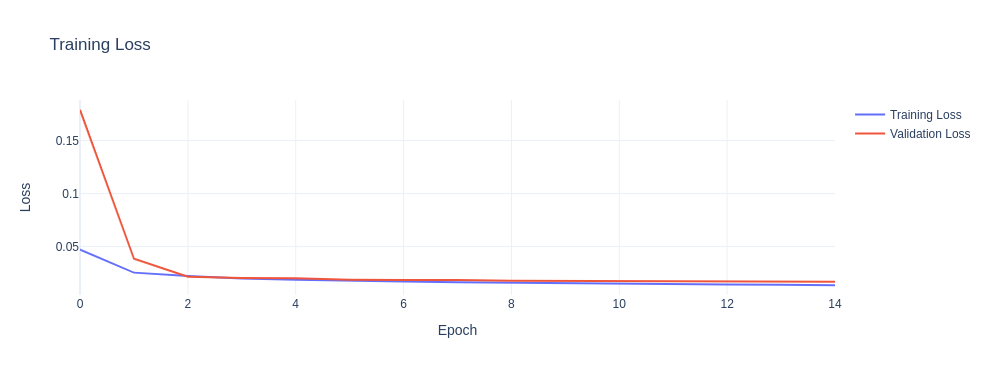

In [112]:
plt_loss(H.history['loss'], H.history['val_loss'])

After a series of tests a conclusion is that the model is very robust. It converges after after around 10 epochs and there is no evidence of overfitting (validation curve stays flat and has slightly higher error than training).

#### Important callout:
It is important that the model still produces some error and does not memorize the whole training set, as this kind of model would not be useful to detect anomalies.

#### How many epochs to choose?
To get an intuition about the relationship of *Sample Size* and *Image Resolution* VS *Seconds per Epoch* and *Epochs to Converge*, I've conducted six experiments with the following results:

| Sample Size | Res.    | Sec. Per Epoch | Epochs to Converge |
|:------------|:-------:|---------------:|-------------------:|
| 10,000      | 56x56   | 2              | 10                 |
| 25,000      | 28x28   | 3              | 20                 |
| 25,000      | 56x56   | 6              | 30                 |
| 25,000      | 112x112 | 15             | 50                 |
| 50,000      | 28x28   | 5              | 50                 |
| 50,000      | 56x56   | 10             | 50                 |
| 50,000      | 112x112 | 28             | 50                 |

As per intuition, the more samples and higher the resolution, the longer it takes to train each epoch. What is interesting is that for smaller sample size ($10K$) and $56x56$ resolution, we can get the convergence in only $20$ epochs, where for larger sample size, we usually need around $50$ epochs to converge.

### Model evaluation on test-set

So the next question is how does this model actually perform on the test-set.

The next step is to use the test-data to see how the model performs in the image reconstruction. We pass the `X_test` to model's `predict` method and we ask the model to recontruct this dataset based on the information encoded in the weights learned from the training data.

The test-set contains $2K$ $56x56$ grayscale images normalized to $0-1$ range.

When predictions are made, we are ready to verify the errors between the original test-set and one reconstructed by the auto-encoder. To calculate errors we will use the same metric as the loss function in the training phase: `mean squared error`. We will append all errors into the `errors` list, which is converted to a numpy array at the end.

In [124]:
%%time

# reconstruct data
reconstructed_data = ae.predict(X_test)

# calculate errors for test-set
errors = []
for (image, recon) in zip(X_test, reconstructed_data):
    # compute the mean squared error between the ground-truth image
    # and the reconstructed image, then add it to our list of errors
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)
errors = np.array(errors)

CPU times: user 297 ms, sys: 14.2 ms, total: 311 ms
Wall time: 254 ms


The whole testing operation (making predictions and calculating errors) is quite fast and takes only $250ms$ for the total of $2K$ test images.

Keeping in mind the two goals from the beginning of this Notebook, we are in position now to solve for both:
- use the difference between tested images and what model has learned from the training data to tell which images are anomalous and if anomalies are detected - trigger an alert
- sort predictions by "most unusual ones" and present to the user as a "Highlights of the day" notification

**Real time image scoring**

Let's say that we want to classify $0.1\%$ of observations as anomalous (this hyperparameter can be tweaked to achieve expected result). Then we search for a 0.99 quantile in the errors, and all images corresponding to the indexes of errors greated than a treshold become anomalies.

Threshold calculation is included below, along with a frequency plot of error distibution with a red dotted line showing the treshold cut off point. Points on the right hand side of the dotted line will be classified as outliers.

In [156]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.99)
idxs = np.where(np.array(errors) >= thresh)[0]
print(f"Mse threshold: {thresh}")
print(f"Outliers found: {len(idxs)}")

Mse threshold: 0.06514995373785494
Outliers found: 20


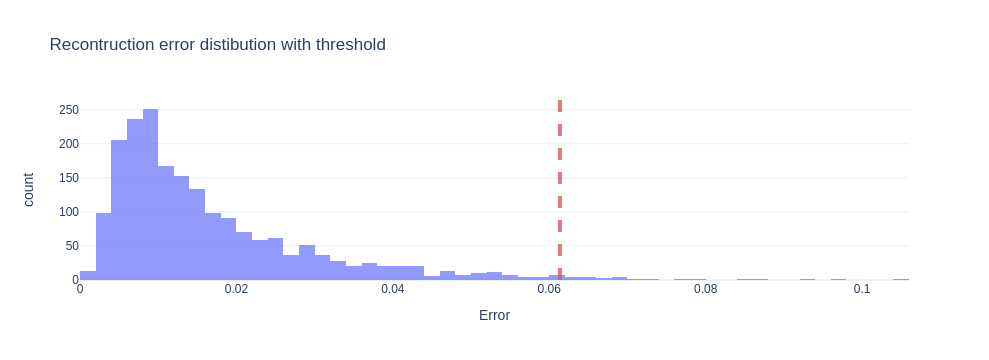

In [138]:
# plot histogram and add a vertical line at the threshold cut off point
fig = px.histogram(x=errors, height=340, width=700, labels={'x': 'Error'},
                   opacity=0.7, title='Recontruction error distibution with threshold')
fig.update_layout(shapes=[
    dict(type='line', yref='paper', y0=0, y1=1, xref='x', x0=thresh, x1=thresh, opacity=0.8,
        line=dict(color="indianred", width=4, dash="dash"))
])

We can now create a new DataFrame and add `is_anomaly` feature based on the error value.

Then we can sort this dataset by error in descending order and view the data behind the observations with highest error:

In [127]:
# take a look at a few images with highest error
errors_df = pd.DataFrame({'mse': errors, 'fpath_name': y_test})
errors_df['is_anomaly'] = 'N'
errors_df.loc[errors_df['mse'] >= thresh, 'is_anomaly'] = 'Y'
errors_df.sort_values('mse', ascending=False).head(7)

,mse,fpath_name,is_anomaly
1268,0.105381,/data/security_cam_detections_v2/Front-Parking/2020-01-04/10.14.44.348_ef38b...,Y
380,0.097850,/data/security_cam_detections_v2/Front-Parking/2019-09-17/11.45.49.816_1b508...,Y
357,0.092499,/data/security_cam_detections_v2/Front-Parking/2020-02-16/12.13.21.737_845dc...,Y
1004,0.087508,/data/security_cam_detections_v2/Front-Parking/2019-11-15/12.42.27.865_250ba...,Y
983,0.084781,/data/security_cam_detections_v2/Front-Parking/2019-09-16/18.24.45.491_fce64...,Y
662,0.084727,/data/security_cam_detections_v2/Front-Parking/2019-12-16/08.39.24.685_1a004...,Y
1773,0.079642,/data/security_cam_detections_v2/Front-Parking/2019-11-17/11.39.18.802_8af1f...,Y


**Highest errors**

No we can see the records with the highest error and display the original image, the test-set and reconstructed versions to understand how the errors are generated.

Error: 0.10538072884082794, img idx: 1268, date: 2020-01-04, file: 10.14.44.348_ef38b569_person.jpg


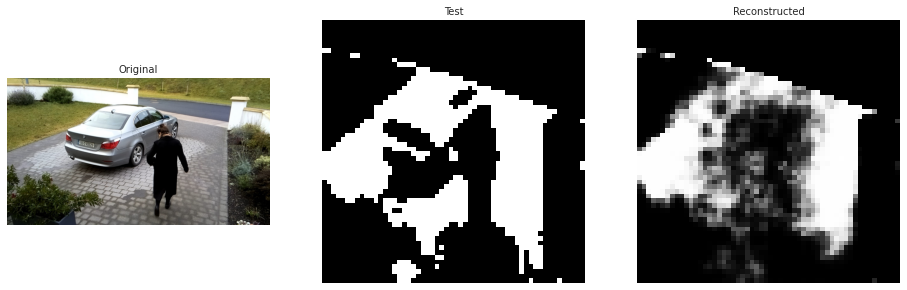

***************************
Error: 0.09785016626119614, img idx: 380, date: 2019-09-17, file: 11.45.49.816_1b5088f1_person-person-car-truck.jpg


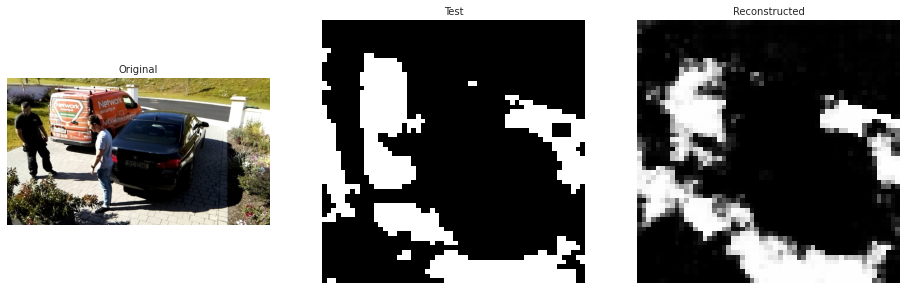

***************************
Error: 0.09249918907880783, img idx: 357, date: 2020-02-16, file: 12.13.21.737_845dc406_person-motorbike.jpg


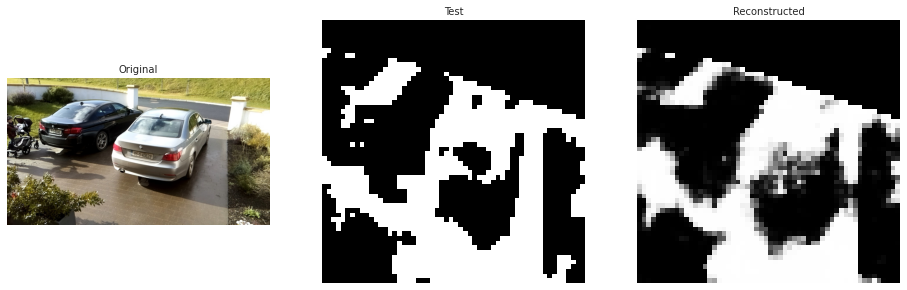

***************************


In [139]:
n_rows = 3
idxs = errors_df.nlargest(n_rows, 'mse').index
for idx in idxs:
    # extract test and reconstructed images and
    # re-normalize and set as uint8, so opencv can read it
    test_img = (X_test[idx] * 255).astype("uint8")
    reconst_img = (reconstructed_data[idx] * 255).astype("uint8")
    
    # find out original image name and load it through open-cv
    img_path = y_test[idx]
    print(f"Error: {errors[idx]}, img idx: {idx}, date: {img_path.split('/')[4]}, file: {img_path.split('/')[5]}")
    im_raw = cv2.imread(img_path)
    
    # plot pair of images
    plt.figure(figsize=(16, 5)) # specifying the overall grid size
    plt.subplot(1, 3, 1) # image 1 in the grid is 1*3
    plt.imshow(cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Original', fontsize=10)
    plt.subplot(1, 3, 2) # image 2 in the grid is 1*3
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Test', fontsize=10)
    plt.subplot(1, 3, 3) # image 3 in the grid is 1*3
    plt.imshow(cv2.cvtColor(reconst_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Reconstructed', fontsize=10)
    plt.axis('off')
    plt.show()
    print('***************************')

As we can see in the set of images above, the procedure does a good enough job at reconstructing test images, and as expected, there is a loss of information in the process.

**Lowest error**

But what if we take a look at a few sample observations with the lowest error? Are they reconstructed better?

Error: 0.00014203618047758937, img idx: 717, date: 2019-12-25, file: 22.43.30.460_7051c777_car.jpg


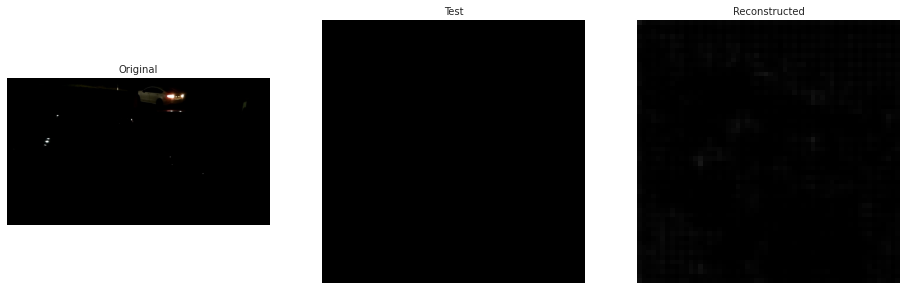

***************************
Error: 0.00014203618047758937, img idx: 1421, date: 2020-02-02, file: 22.55.52.050_4758b42e_car.jpg


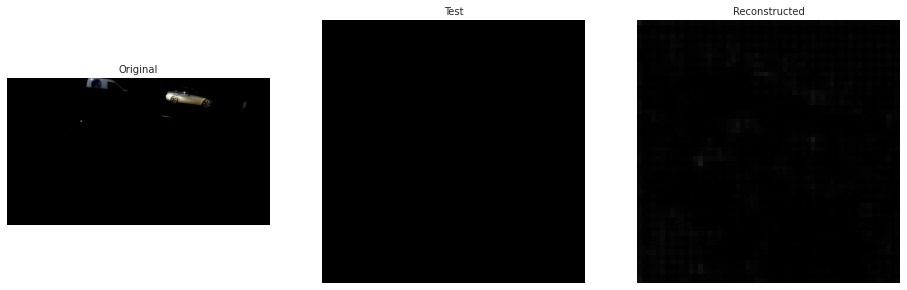

***************************
Error: 0.00014203618047758937, img idx: 1604, date: 2020-02-01, file: 17.56.26.997_bb5b31b6_car.jpg


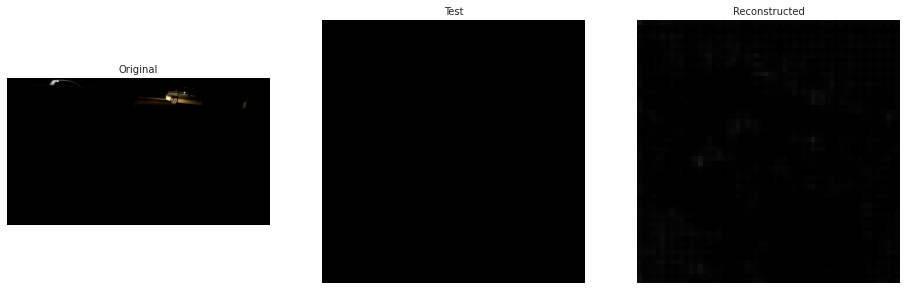

***************************
Error: 0.00014203618047758937, img idx: 1895, date: 2020-02-02, file: 21.40.29.466_b527d7c5_car.jpg


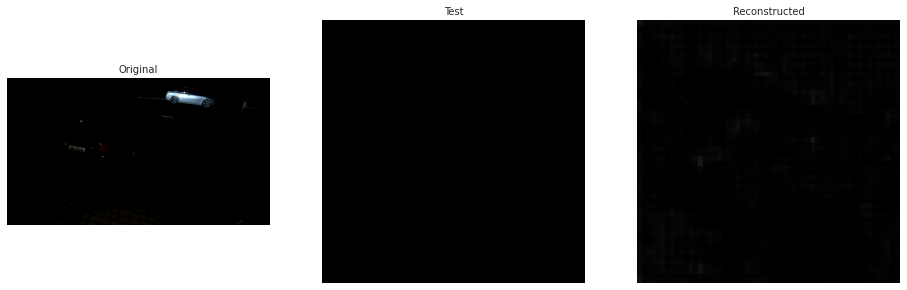

***************************
Error: 0.0001420361950295046, img idx: 459, date: 2020-02-02, file: 19.31.40.188_475b5992_car-car.jpg


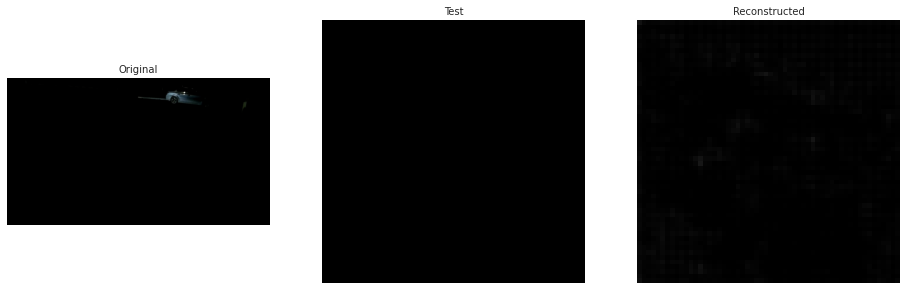

***************************


In [157]:
n_rows = 5
idxs = errors_df.nsmallest(n_rows, 'mse').index
for idx in idxs:
    # extract test and reconstructed images and
    # re-normalize and set as uint8, so opencv can read it
    test_img = (X_test[idx] * 255).astype("uint8")
    reconst_img = (reconstructed_data[idx] * 255).astype("uint8")
    
    # find out original image name and load it through open-cv
    img_path = y_test[idx]
    print(f"Error: {errors[idx]}, img idx: {idx}, date: {img_path.split('/')[4]}, file: {img_path.split('/')[5]}")
    im_raw = cv2.imread(img_path)
    
    # plot pair of images
    plt.figure(figsize=(16, 5)) # specifying the overall grid size
    plt.subplot(1, 3, 1) # image 1 in the grid is 1*3
    plt.imshow(cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Original', fontsize=10)
    plt.subplot(1, 3, 2) # image 2 in the grid is 1*3
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Test', fontsize=10)
    plt.subplot(1, 3, 3) # image 3 in the grid is 1*3
    plt.imshow(cv2.cvtColor(reconst_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Reconstructed', fontsize=10)
    plt.axis('off')
    plt.show()
    print('***************************')

So this is actually suprising, but it makes intuitive sense. The first $8$ images are very dark and contain a lot of pixels with a value of zero, so reconstructing those is much easier for the model and therefore the error will be much lower as well.

So, what can we say about the output of the procedure?

It shows a good potential. The images classified as anomalous are different enough from the most common observations with low unusual activity and with more search for the optimal parameters, it can be optimized further. We can expect that with even more different images, the reconstruction error will be greater again, which will flag them as anomalous correctly.

It most likely needs some improvements in the data collection stage, and perhaps more computer vision preprocessing steps (for example one of the images with highest error was flagged due to the dry patches of otherwise wet surface, and perhaps more sensitivity is required when it's dark).

It would also make sense to introduce a flag in the system if owners are currently occupying home, as alert should probably be triggered when owners are not at home.

Finally the training procedure needs to be carefully crafted. Instead of training the model on the whole data, a better idea would be to train on a few rolling months. This would help if an area changes over time (people change their cars or plant new trees, or even move the camera to another location).

But all these dilemmas open up a lot of opportunities for the future improvements.

### Evaluation on hand-labelled data

The very last step in terms of auto-encoder analysis is to see how it behaves when we feed it with the hand-picked images.

This will allow to generate metrics, which models can be compared with. Otherwise how would we know which model is better?

I have annotated 30 images:
- 15 as non-anomalous
- 15 as anomalous

The process is almost the same as error calculation in the previous step (I have defined a function called `test_anomalies` for this task):
- load images from the disk (non-anomalous and anomalous samples reside in their respective 0 and 1 folders)
- preprocess images and reshape
- run prediction through autoencoder Keras model
- calculate mean squared errors
- establish if we found an anomaly based on a given threshold
- show images (optionaly)
- plot errors from autoencoder (optionaly)
- return anomaly flags for each image in the folder

In [151]:
def test_anomalies(test_dir, ae, errors, thresh, show_images=True, show_err_plt=True,
                   only_misclassified=False):
    """
    Function to read images from a folder and use auto-encoder
    to reconstruct those, perform anomaly analysis and return
    accuracy of anomaly detection
    """
    
    # collect stats throughout training
    true_vals = []
    predicted_vals = []
    
    # initialize threshold line for the error histogram plot
    shapes = [
        dict(type='line', yref='paper', y0=0, y1=1, xref='x', x0=thresh, x1=thresh,
             opacity=0.6, line=dict(color="indianred", width=4, dash="dash"))
    ]
    
    # loop through 0 and 1 folders inside the test_dir, which
    # are corresponding to non-anomalous and anomalous image samples
    for dir_name in ['0', '1']:
        
        # figure out is_anomaly flag from the folder name
        is_anomaly = bool(int(dir_name))
        
        # read images
        orig_imgs = []
        processed_imgs = []
        for img in os.listdir(f'{test_dir}/{dir_name}'):
            if 'ipynb' in img:  # skip any Jupyter related files/folders !
                continue
            orig_img = cv2.imread(f'{test_dir}/{dir_name}/{img}')
            orig_imgs.append(orig_img)
            processed_imgs.append(process_frame(orig_img, (WIDTH, HEIGHT), True, True, True, True, POLY_VALUES))
        orig_imgs = np.array(orig_imgs)
        processed_imgs = np.array(processed_imgs)

        # reshape processed images to Keras CNN expectated format (with channel dimension)
        processed_imgs = np.squeeze(processed_imgs)
        processed_imgs = np.expand_dims(processed_imgs, axis=-1)
        processed_imgs = processed_imgs.astype("float32") / 255.0

        # use autoencoder to reconstruct images
        reconstructed_data = ae.predict(processed_imgs)

        # calculate errors between processed and reconstructed images
        # calculate errors for test-set
        test_errors = []
        for (image, recon) in zip(processed_imgs, reconstructed_data):
            # compute the mean squared error between the ground-truth image
            # and the reconstructed image, then add it to our list of errors
            mse = np.mean((image - recon) ** 2)
            test_errors.append(mse)
        test_errors = np.array(test_errors)

        for idx, im in enumerate(processed_imgs):
            # extract test and reconstructed images and
            # re-normalize and set as uint8, so opencv can read it
            test_img = (processed_imgs[idx] * 255).astype("uint8")
            reconst_img = (reconstructed_data[idx] * 255).astype("uint8")

            # figure out if the image is an anomaly
            if test_errors[idx] >= thresh:
                found_anomaly = True
            else:
                found_anomaly = False
            
            # append values to stats
            true_vals.append(is_anomaly)
            predicted_vals.append(found_anomaly)
            
            if show_images:
                if not only_misclassified or (only_misclassified and is_anomaly != found_anomaly):
                    print(f'True class: {is_anomaly}, predicted class: {found_anomaly}')
                    # plot pair of images
                    plt.figure(figsize=(16, 5)) # specifying the overall grid size
                    plt.subplot(1, 3, 1) # image 1 in the grid is 1*3
                    plt.imshow(cv2.cvtColor(orig_imgs[idx], cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.title(f'Original', fontsize=10)
                    plt.subplot(1, 3, 2) # image 2 in the grid is 1*3
                    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.title(f'Test', fontsize=10)
                    plt.subplot(1, 3, 3) # image 3 in the grid is 1*3
                    plt.imshow(cv2.cvtColor(reconst_img, cv2.COLOR_BGR2RGB))
                    plt.title(f'Reconstructed', fontsize=10)
                    plt.axis('off')
                    plt.show()
                    print('***************************')
            
        for err in test_errors:
            line_color = 'red' if is_anomaly else '#5fbaa7'
            shapes.append(dict(type='line', yref='paper', y0=0, y1=0.14, xref='x', x0=err, x1=err,
                               opacity=0.9, line=dict(color=line_color, width=1)))
    
    if show_err_plt:
        # plot histogram and add a vertical line at the threshold cut off point
        fig = px.histogram(x=errors, height=360, labels={'x': 'Reconstruction Error'}, opacity=0.5,
                           title='Recontruction errors for anomalies and non-anomalies')
        
        fig.update_layout(shapes=shapes)
        fig.show()

    # return true labels and predicted based on the threshold
    return true_vals, predicted_vals

#### Evaluation metrics:

Since we have the labels now, this is becoming a supervised Machine Learning problem, and we can use the standard classification metrics to evaluate model's perfmance.

Here are the most relevant metrics, as described in an [online article](https://stackabuse.com/understanding-roc-curves-with-python/):

- Accuracy

Accuracy measures a percentage of correct predictions out of all predictions:

$$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$

where $TP$ are True Positives, $TN$ are True Negatives, $FP$ are False Positives and $FN$ are False Negatives

- Precision

Precision tends to be a good metric when the cost of False Positives is high. Out of all the predicted positive instances, how many were predicted correctly:

$$Precision=\frac{TP}{TP+FP}$$

- Recall

Contrary to Precision, Recall is a useful metric when the cost of False Negatives is high. Out of all the positive classes, how many instances were identified correctly:

$$Recall=\frac{TP}{TP+FN}$$

- F1 Score

F1 Score is a mixture of Precision and Recall in a single metric (when classifying 0's and 1's correctly are both equally important). F1 Measure is nothing but the harmonic mean of Precision and Recall:

$$F1=2*\frac{Precision*Recall}{Precision+Recall}$$

In the case of anomaly detection accuracy tends to be a poor measure due to the dominanace of the *Normal* observations. Precision is also not the most useful metric, as the cost of falsly classifying observation as an anomaly tends to be less detrimental than not catching the anomaly at all.

As a result of the above statements, **Recall** will be the most important metric to observe, while keeping an eye on the F1 Score to make sure we don't sacrifice too much on the other type of errors.

Below I will plot the overall test-set error distribution with the red dashed line representing the anomaly threshold, and I will also plot a line for each observation classified as anomaly (red solid lines) and non-anomaly (green solid lines).

Then I will display the misclassified images, scores for each evaluated metric along with the **Confusion Matrix**, which tells us where exactly model makes mistakes:

True class: False, predicted class: True


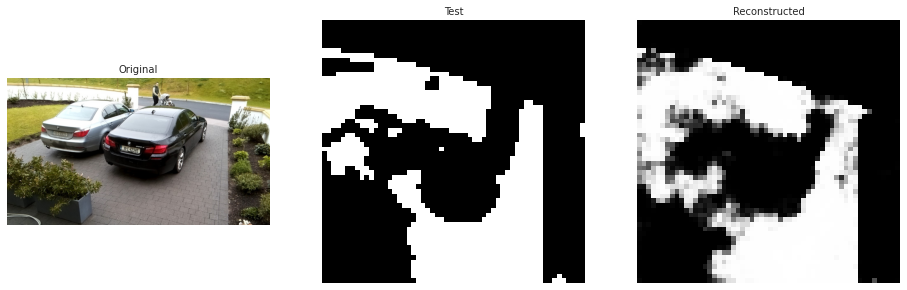

***************************
True class: True, predicted class: False


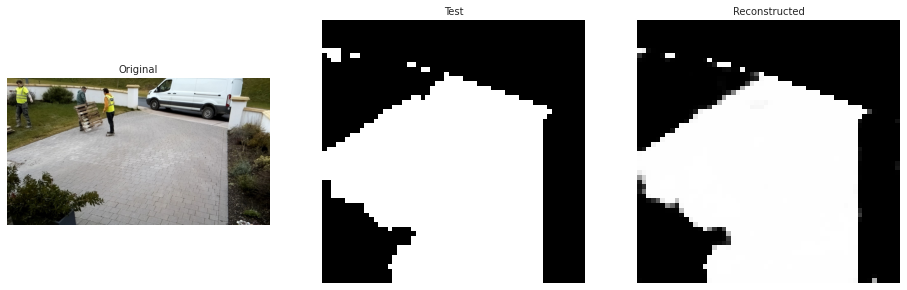

***************************
True class: True, predicted class: False


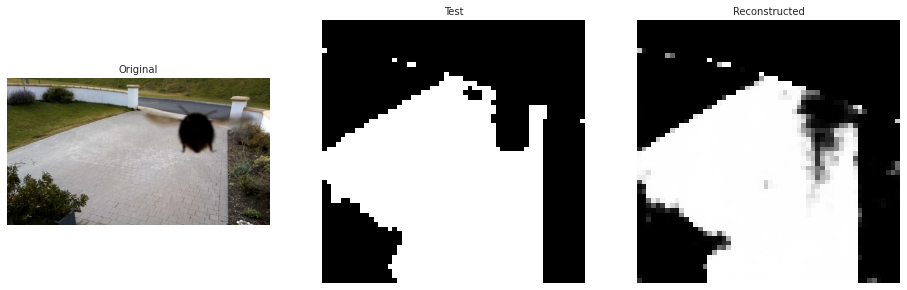

***************************
True class: True, predicted class: False


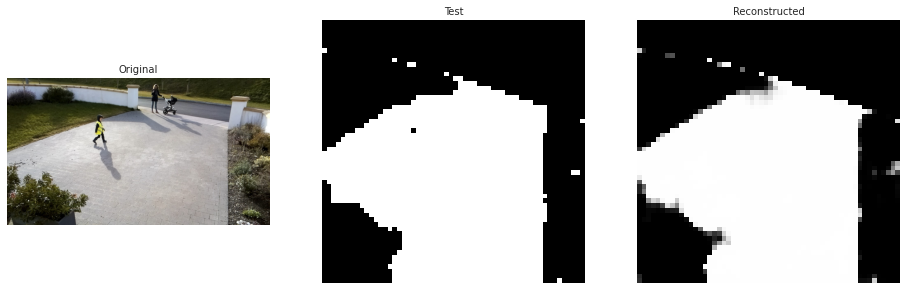

***************************
True class: True, predicted class: False


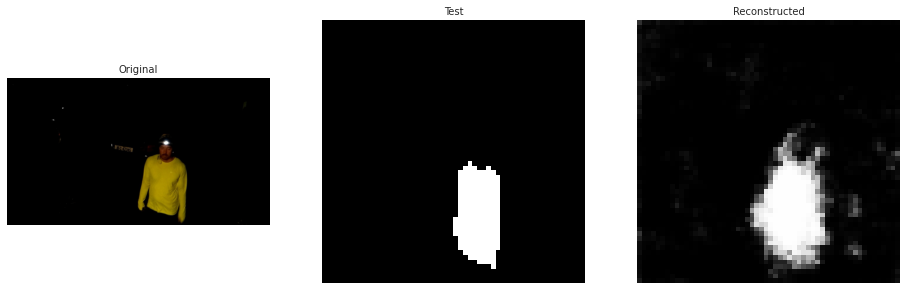

***************************
True class: True, predicted class: False


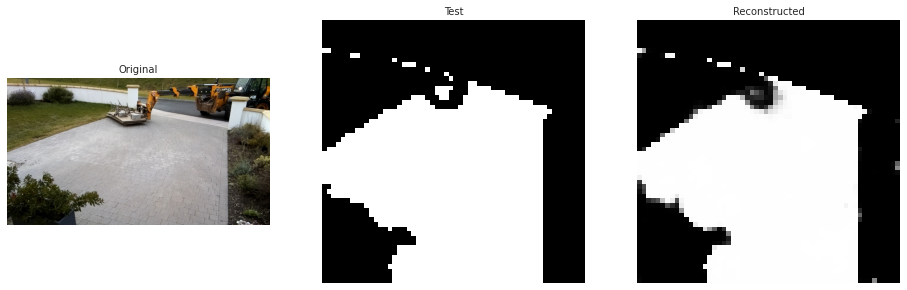

***************************
True class: True, predicted class: False


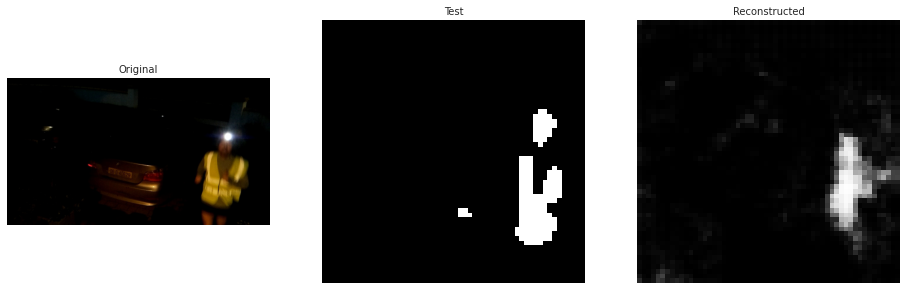

***************************


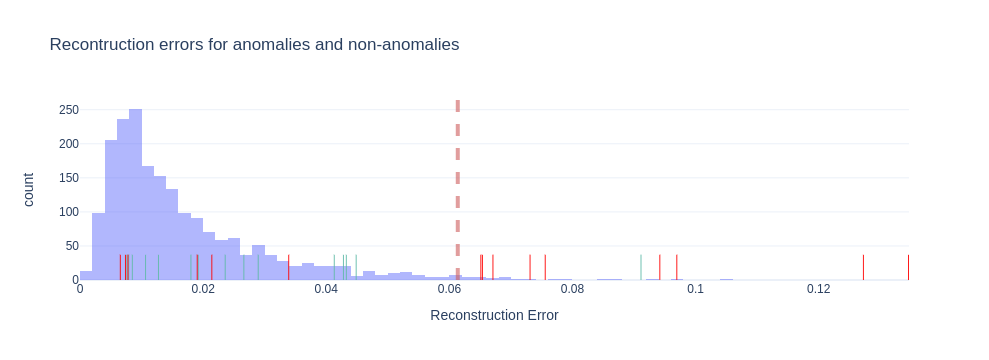

** Confusion Matrix:
    0  1
0  14  1
1   6  9

**Scores:
        acc  prec  rec    f1                                        model_name
0  0.766667   0.9  0.6  0.72  nsamples10000_res56_blurTrue_threshTrue_polyTrue


In [153]:
test_dir = '../Datasets/anomalies_labelled'
true_vals, pred_vals = test_anomalies(test_dir, ae, errors, thresh, show_images=True, show_err_plt=True,
                                      only_misclassified=True)

# convert booleans to integers, so we can calculate scores
true_vals_int = [int(v) for v in true_vals]
pred_vals_int = [int(v) for v in pred_vals]

# calculate score
from sklearn.metrics import (confusion_matrix, recall_score, accuracy_score,
                             precision_score, f1_score, roc_curve, roc_auc_score)
cm = confusion_matrix(true_vals_int, pred_vals_int)
acc_score = accuracy_score(true_vals_int, pred_vals_int)
prec_score = precision_score(true_vals_int, pred_vals_int)
rc_score = recall_score(true_vals_int, pred_vals_int)
f_score = f1_score(true_vals_int, pred_vals_int)

# print results
print('** Confusion Matrix:')
print(pd.DataFrame(cm).head())
scores = {'acc': acc_score, 'prec': prec_score, 'rec': rc_score, 'f1': f_score}
scores['model_name'] = model_name
scores = pd.DataFrame([scores])
print('')
print('**Scores:')
print(scores.head())

**Results:**

- Images: All misclassified images can be explained by not enough variaty against what is seen as a normal frame. I think the best improvement would be to apply some computer vision to detect when it's dark and increase error sensitivity during nightly hours.
- Plot: The plot shows $6$ anomalous images misclassfied out of $15$. This means that the system "as-is" could pick up $60\%$ of anomalies. Most of the incorrect predictions are actually questionable and quite hard to classify
- Metrics: Metrics show relativaly good scores with potential opportunities for improvements (especially around the Recall area)

**Model comparison**

Below are all the models, which I have tested to select the best model. It seems like a model with only $10K$ $56x56$ images performs the best, it is very robust and should be used going forward.

In [122]:
# add model to score history (avoid duplicate entries first)
idx = SCORE_HISTORY['model_name'] == model_name
SCORE_HISTORY = SCORE_HISTORY.loc[~idx]
SCORE_HISTORY = SCORE_HISTORY.append(scores)
SCORE_HISTORY.to_csv('../Datasets/model_scores/scores.csv', index=False)
SCORE_HISTORY.sort_values(['f1', 'rec'], ascending=False)

,model_name,acc,prec,rec,f1
0,nsamples25000_res56_blurTrue_threshTrue_polyTrue,0.766667,0.900000,0.600000,0.720000
0,nsamples10000_res56_blurTrue_threshTrue_polyTrue,0.766667,0.900000,0.600000,0.720000
7,nsamples10000_res56_blurTrue_threshTrue_polyTrue_RELU,0.766667,0.900000,0.600000,0.720000
3,nsamples25000_res56_blurTrue_threshFalse_polyTrue,0.500000,0.500000,1.000000,0.666667
8,nsamples10000_res56_blurTrue_threshTrue_polyTrue_RELU_LESS_CONV_FILTERS,0.733333,0.888889,0.533333,0.666667
0,nsamples50000_res112_blurTrue_threshTrue_polyTrue,0.700000,0.800000,0.533333,0.640000
2,nsamples50000_res28_blurTrue_threshTrue_polyTrue,0.700000,0.875000,0.466667,0.608696
5,nsamples2000_res56_blurTrue_threshTrue_polyTrue,0.700000,0.875000,0.466667,0.608696
9,nsamples10000_res56_blurTrue_threshTrue_polyTrue_RELU_NO_LR_DECAY,0.700000,0.875000,0.466667,0.608696
1,nsamples25000_res56_blurTrue_threshTrue_polyFalse,0.466667,0.478261,0.733333,0.578947


### Next steps

The next improvements here would be:
- spend more time on tuning model parameters
- test a more advanced auto-encoder architecture (Variational Auto-Encoder)
- improve data injestion pipeline (better cameras with night vision, better detection algorithms and logic)
- add more computer vision tricks to improve anomaly detection in the dark